In [1]:
import gc
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv2D, GlobalMaxPooling2D, Concatenate, Dense, Dropout, Reshape
from tensorflow.keras.models import Model
import numpy as np
import gc
import pandas as pd
from sklearn.decomposition import PCA
import random

In [2]:
root_dir = './'
def get_data(label, count, total=1500):
    data = []
    samples = random.choices(range(0, total), k=count)
    for i in samples:
        file_data = open(root_dir+f'{label}_500/{label}_{str(i).zfill(4)}/data_section.bin', 'rb').read()
        bytes_sequence = np.frombuffer(file_data, dtype=np.uint8)
        data.append(bytes_sequence)
        np.random.shuffle(data)
    return data

In [3]:
import os
def get_benign_data():
    data = []
    i = 1

    while True:
        folder_path = os.path.join(root_dir, f"Benign_500/Benign_{str(i).zfill(4)}")
        if not os.path.exists(folder_path):
            break

        j = 1
        while True:
            chunk_path = os.path.join(folder_path, f"data_section_chunk_{j}.bin")
            if not os.path.exists(chunk_path):
                break

            with open(chunk_path, 'rb') as file_data:
                bytes_sequence = np.frombuffer(file_data.read(), dtype=np.uint8)
                data.append(bytes_sequence)

            j += 1

        i += 1
    return data


In [4]:
TOTAL_ADWARE_SAMPLE = 1500
TOTAL_SMS_SAMPLE = 4800
TOTAL_BANKING_SAMPLE = 2200

In [5]:
gc.collect()
benign_data = get_benign_data()
adware_data = get_data('Adware', TOTAL_ADWARE_SAMPLE, 1500)
sms_data = get_data('SMS', TOTAL_SMS_SAMPLE, 4800)
banking_data = get_data('Banking', TOTAL_BANKING_SAMPLE, 2200)
MALWARE_SAMPLE = TOTAL_ADWARE_SAMPLE + TOTAL_SMS_SAMPLE + TOTAL_BANKING_SAMPLE
BENIGN_SAMPLE = len(benign_data)
gc.collect()

0

In [69]:
labels = np.array([0 for i in range(BENIGN_SAMPLE)] + [1 for i in range(MALWARE_SAMPLE)])

In [7]:


# Apply PCA to reduce features to 256 components
pca = PCA(n_components=256)
pca_pre = pca.fit_transform(np.concatenate((np.array(benign_data[:200]), np.array(adware_data[:200]), np.array(sms_data[:200]), np.array(banking_data[:200])),axis=0))

In [8]:
def transform_data(data):
    n_part = len(data) // 1000
    parts = [data[i*1000:(i+1)*1000] for i in range(n_part)] + [data[n_part*1000:]]
    res = []
    for part in parts:
        res.extend(pca.transform(part))
    
    gc.collect()
    return res

In [9]:
gc.collect()
features_pca_benign = transform_data(benign_data)
features_pca_adware = transform_data(adware_data)
features_pca_sms = transform_data(sms_data)
features_pca_banking = transform_data(banking_data)

features_pca = np.concatenate((features_pca_benign, features_pca_adware, features_pca_sms, features_pca_banking), axis=0)

In [10]:
print(len(features_pca))

20023


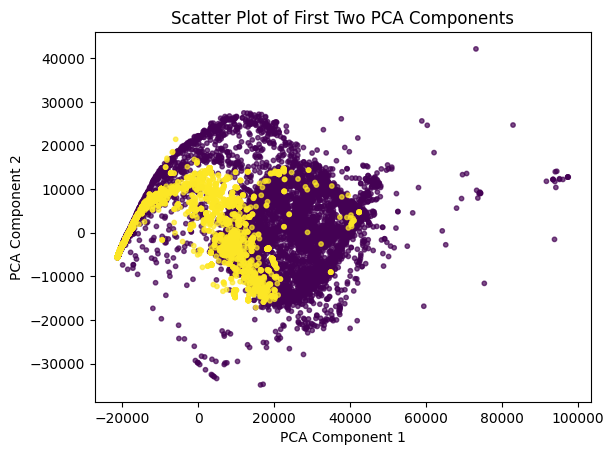

In [62]:
import matplotlib.pyplot as plt
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=labels, cmap='viridis', alpha=0.7, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Scatter Plot of First Two PCA Components')
plt.show()

NameError: name 'X_pca' is not defined

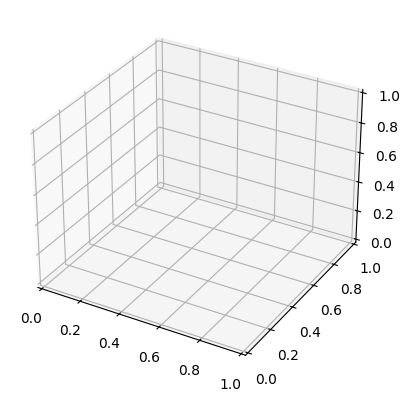

In [89]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_scaled[:, 0], features_scaled[:, 1], features_scaled[:, 2], alpha=0.7, s=10)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

In [70]:
min_val = np.min(features_pca, axis=0)  # Use numpy here for compatibility
max_val = np.max(features_pca, axis=0)
features_scaled = 2 * (features_pca - min_val) / (max_val - min_val) - 1  # Scale to [-1, 1]

# Reshape features to (None, 16, 16, 1)
features_reshaped = np.reshape(features_scaled, [-1, 16, 16, 1])  # Adjust to match data shape

# Convert features and labels to TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((features_reshaped, labels))



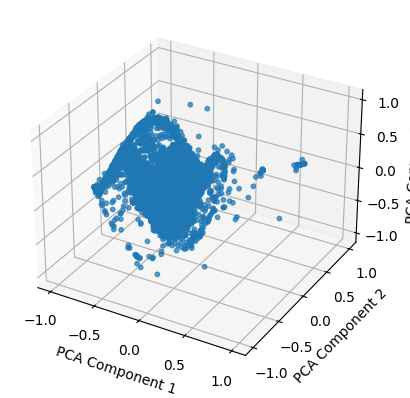

In [ ]:
import matplotlib.pyplot as plt
label_to_color = {0: 'Benign', 1: 'Malware'}
scatter_colors = [label_to_color[label] for label in labels]
scatter = plt.scatter(features_scaled[12000:, 0], features_scaled[12000:, 1], c=labels[12000:], cmap='viridis', alpha=0.7, s=10)
for label in np.unique(labels):
    plt.scatter([], [], color=scatter.to_rgba(label), label=label_to_color[label])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Scatter Plot of First Two PCA Components')
plt.legend(title="Classes")
plt.show()
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_scaled[:, 0], features_scaled[:, 1], features_scaled[:, 2], c=labels[12000:], cmap='viridis', alpha=0.7, s=10)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

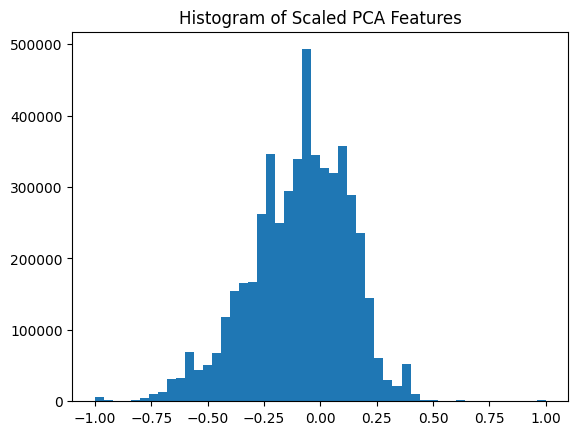

In [59]:
plt.hist(features_scaled.flatten(), bins=50)
plt.title('Histogram of Scaled PCA Features')
plt.show()


In [12]:
NUMBER_OF_SAMPLE = MALWARE_SAMPLE + BENIGN_SAMPLE

In [13]:
# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=NUMBER_OF_SAMPLE, seed=123)

# Split into training and validation datasets
train_size = int(0.8 * NUMBER_OF_SAMPLE)  # 80% for training
train_dataset = dataset.take(train_size)  # First 80%
val_dataset = dataset.skip(train_size)    # Remaining 20%

# Batch the datasets
batch_size = 64  # You can adjust this
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)


In [14]:
for x_batch, y_batch in train_dataset.take(1):
    print("Input batch shape:", x_batch.shape)
    print("Label batch shape:", y_batch.shape)

Input batch shape: (64, 16, 16, 1)
Label batch shape: (64,)


In [15]:
# Define input
input_layer = Input(shape=(16, 16, 1), name="Input_Layer")

# Convolutional and pooling layers
conv_layers = []
for kernel_size in [2, 3, 4, 5, 6, 7, 8]:
    x = Conv2D(filters=64, kernel_size=(kernel_size, kernel_size), activation='relu', padding='same',
               name=f"Conv2D_Kernel_{kernel_size}")(input_layer)
    x = Dropout(0.3, name=f"Dropout_Conv2D_{kernel_size}")(x)
    pooled = GlobalMaxPooling2D(name=f"GlobalMaxPooling_Kernel_{kernel_size}")(x)
    conv_layers.append(pooled)

# Aggregation
aggregation_layer = Concatenate(name="Aggregation_Layer")(conv_layers)
aggregation_layer = Dropout(0.5, name="Dropout_Aggregation")(aggregation_layer)
# Fully connected layer with Dropout
fully_connected = Dense(128, activation='relu', name="Fully_Connected_Layer")(aggregation_layer)
dropout_layer = Dropout(0.5, name="Dropout_Layer")(fully_connected)

# Output layer
output_layer = Dense(2, activation='softmax', name="Output_Layer")(dropout_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer, name="CNN_Model")

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 16, 16, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_Kernel_2     │ (None, 16, 16,    │        320 │ Input_Layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_Kernel_3     │ (None, 16, 16,    │        640 │ Input_Layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_Kernel_4     │ (None, 16, 16,    │      1,088 │ Input_Layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_Kernel_5     │ (None, 16, 16,    │      1,664 │ Input_Layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_Kernel_6     │ (None, 16, 16,    │      2,368 │ Input_Layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_Kernel_7     │ (None, 16, 16,    │      3,200 │ Input_Layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_Kernel_8     │ (None, 16, 16,    │      4,160 │ Input_Layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Conv2D_2    │ (None, 16, 16,    │          0 │ Conv2D_Kernel_2[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Conv2D_3    │ (None, 16, 16,    │          0 │ Conv2D_Kernel_3[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Conv2D_4    │ (None, 16, 16,    │          0 │ Conv2D_Kernel_4[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Conv2D_5    │ (None, 16, 16,    │          0 │ Conv2D_Kernel_5[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Conv2D_6    │ (None, 16, 16,    │          0 │ Conv2D_Kernel_6[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Conv2D_7    │ (None, 16, 16,    │          0 │ Conv2D_Kernel_7[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Conv2D_8    │ (None, 16, 16,    │          0 │ Conv2D_Kernel_8[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalMaxPooling_K… │ (None, 64)        │          0 │ Dropout_Conv2D_2… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalMaxPooling_K… │ (None, 64)        │          0 │ Dropout_Conv2D_3

 Total params: 71,170 (278.01 KB)

 Trainable params: 71,170 (278.01 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    batch_size=batch_size,
    epochs=20,  # Adjust epochs as needed
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6978 - loss: 0.5705 - val_accuracy: 0.9321 - val_loss: 0.2162
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9166 - loss: 0.2653 - val_accuracy: 0.9401 - val_loss: 0.1935
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9263 - loss: 0.2359 - val_accuracy: 0.9406 - val_loss: 0.1892
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9362 - loss: 0.2021 - val_accuracy: 0.9411 - val_loss: 0.1954
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9362 - loss: 0.1994 - val_accuracy: 0.9518 - val_loss: 0.1561
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9410 - loss: 0.1846 - val_accuracy: 0.9551 - val_loss: 0.1413
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9456 - loss: 0.1714 - val_accuracy: 0.9546 - val_loss: 0.1295
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9507 - loss: 0.1592 - val_acc

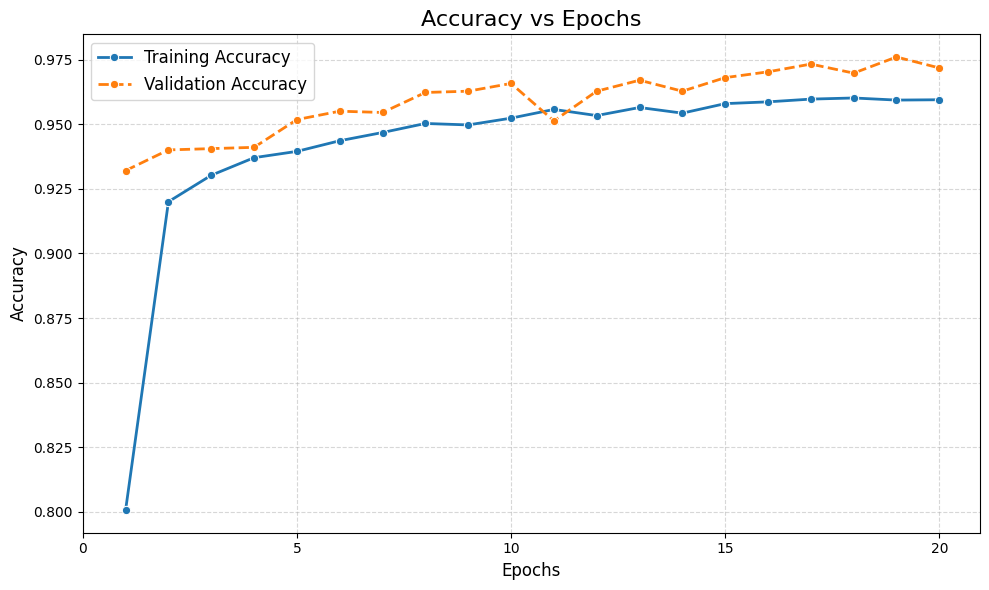

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'history' is the output from model.fit()
# Extract accuracy and epochs from history
epochs = range(1, len(history.history['accuracy']) + 1)
data = {
    'Epochs': list(epochs),
    'Training Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy']
}

# Convert data to a Pandas DataFrame for easier plotting
df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Epochs', y='Training Accuracy', marker='o', label='Training Accuracy', linewidth=2)
sns.lineplot(data=df, x='Epochs', y='Validation Accuracy', marker='o', label='Validation Accuracy', linewidth=2, linestyle='--')
plt.title('Accuracy vs Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.xticks(ticks=range(0, len(epochs) + 1, 5))
plt.ylabel('Accuracy', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [17]:
sms_4800 = open('./SMS_500/SMS_4810/data_section.bin', 'rb').read()
bytes_sequence = np.frombuffer(sms_4800, dtype=np.uint8)
transformed_sms_4800 = pca.transform([bytes_sequence])
sms_4800_scaled = 2 * (transformed_sms_4800 - min_val) / (max_val - min_val) - 1  # Scale to [-1, 1]
sms_4800_reshaped = np.reshape(sms_4800_scaled, [1, 16, 16, 1])
prediction = model.predict(sms_4800_reshaped)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[[0.03336448 0.9666355 ]]


In [18]:
banking_1000 = open('./Banking_500/Banking_2210/data_section.bin', 'rb').read()
bytes_sequence = np.frombuffer(banking_1000, dtype=np.uint8)
transformed_banking_1000 = pca.transform([bytes_sequence])
banking_1000_scaled = 2 * (transformed_banking_1000 - min_val) / (max_val - min_val) - 1  # Scale to [-1, 1]
banking_1000_reshaped = np.reshape(banking_1000_scaled, [1, 16, 16, 1])
prediction = model.predict(banking_1000_reshaped)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.00244218 0.99755776]]


In [19]:
adware_1500 = open('./Adware_500/Adware_1510/data_section.bin', 'rb').read()
bytes_sequence = np.frombuffer(adware_1500, dtype=np.uint8)
transformed_adware_1500 = pca.transform([bytes_sequence])
adware_1500_scaled = 2 * (transformed_adware_1500 - min_val) / (max_val - min_val) - 1  # Scale to [-1, 1]
adware_1500_reshaped = np.reshape(adware_1500_scaled, [1, 16, 16, 1])
prediction = model.predict(adware_1500_reshaped)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.02534951 0.97465044]]


In [20]:
benign_0590 = open('./Benign_500/Benign_0557/data_section_chunk_1.bin', 'rb').read()
bytes_sequence = np.frombuffer(benign_0590, dtype=np.uint8)
transformed_benign_0590 = pca.transform([bytes_sequence])
benign_0590_scaled = 2 * (transformed_benign_0590 - min_val) / (max_val - min_val) - 1 # Scale to [-1, 1]
benign_0590_reshaped = np.reshape(benign_0590_scaled, [1, 16, 16, 1])
prediction = model.predict(benign_0590_reshaped)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.98607963 0.01392032]]


In [21]:
y_true = []
y_pred = []

for X_batch, Y_batch in val_dataset:
    predictions = model.predict(X_batch)  # Shape: (batch_size, 2)
    predicted_classes = np.argmax(predictions, axis=1)  # Get class indices (0 or 1)
    y_true.extend(Y_batch.numpy())  # Add true labels
    y_pred.extend(predicted_classes)  # Add predictions

y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

In [22]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2198   70]
 [  38 1699]]


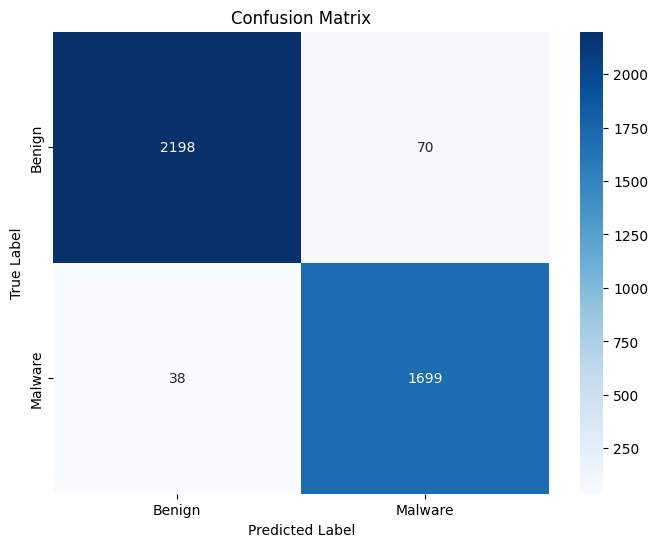

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6 ))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [28]:
seq = []
for i in range(1,2):
    chunk = open(f'./classes_data_section_chunk_{4}.bin', 'rb').read()
    bytes_sequence = np.frombuffer(chunk, dtype=np.uint8)
    seq.append(bytes_sequence)

transformed = pca.transform(seq)
scaled = 2 * (transformed - min_val) / (max_val - min_val) - 1  # Scale to [-1, 1]
reshaped = np.reshape(scaled, [1, 16, 16, 1])
prediction = model.predict(reshaped)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.5047163 0.4952837]]


In [29]:
label = 'Benign'
seq = []
for i in range(600):
    file_data = open(root_dir+f'old_{label}_500/{label}_{str(i).zfill(4)}/data_section.bin', 'rb').read()
    bytes_sequence = np.frombuffer(file_data, dtype=np.uint8)
    seq.append(bytes_sequence)

transformed = pca.transform(seq)
# transformed = seq
scaled = 2 * (transformed - min_val) / (max_val - min_val) - 1  # Scale to [-1, 1]
reshaped = np.reshape(scaled, [-1, 16, 16, 1])
prediction = model.predict(reshaped)
print(prediction)
print(sum(np.argmax(prediction, axis=1)))



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[0.9885648  0.01143525]
 [0.6297907  0.37020928]
 [0.6746879  0.32531214]
 ...
 [0.9318227  0.06817728]
 [0.9790547  0.02094533]
 [0.9645718  0.03542819]]
49


In [52]:
seq = []
for i in range(1,3):
    file_data = open(f'./test/92f211adb0da4cd916dd9f7e74582abe2fdf4d35fc590c99db297114949c5643/classes_data_section_chunk_{i}.bin', 'rb').read()
    bytes_sequence = np.frombuffer(file_data, dtype=np.uint8)
    seq.append(bytes_sequence)

transformed = pca.transform(seq)
# transformed = seq
scaled = 2 * (transformed - min_val) / (max_val - min_val) - 1  # Scale to [-1, 1]
reshaped = np.reshape(scaled, [-1, 16, 16, 1])
prediction = model.predict(reshaped)
print(prediction)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.34765694 0.6523431 ]
 [0.98078144 0.01921853]]
